# Example - parallel computation

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pygmsh
from ttcrpy import tmesh
from numpy.random import default_rng

Define a function for slowness

In [2]:
def f(z):
    return 1.0 / (1.5 + 4.5*z)

In [3]:
geom = pygmsh.built_in.Geometry()
lcar = 0.042
geom.add_box(0.0, 1.0, 0.0, 1.0, 0.0, 1.0, lcar=lcar)
msh = pygmsh.generate_mesh(geom, verbose=False)

Create slowness field, source and receivers

In [4]:
slowness = f(msh.points[:,2])

rng = default_rng(1966)

src = rng.uniform(0.01, 0.99, (10, 3))  # 10 src points
rcv = rng.uniform(0.05, 0.95, (20, 3))  # 20 receivers

# src & rcv must have the same number of rows, with rows corresponding to src-rcv pairs
src = np.kron(np.ones((20, 1)), src)
rcv = np.kron(rcv, np.ones((10, 1)))

Create an instance of Mesh3d that will run with 1 thread

In [5]:
tm = tmesh.Mesh3d(msh.points, tetra=msh.cells_dict['tetra'], method='DSPM', cell_slowness=0,
                  radius_tertiary=0.1)
tm.set_slowness(slowness)

In [6]:
tstart = time.time()
tt1 = tm.raytrace(src, rcv)
tend1 = time.time() - tstart
print('time serial = ', tend1)

time serial =  11.42505407333374


Create another instance of Mesh3d that will run with 4 threads

In [7]:
tm2 = tmesh.Mesh3d(msh.points, tetra=msh.cells_dict['tetra'], method='DSPM', cell_slowness=0,
                   n_threads=4, radius_tertiary=0.1)
tm2.set_slowness(slowness)

In [8]:
tstart = time.time()
try:
    tt2 = tm2.raytrace(src, rcv)
except e:
    print(e)
tend2 = time.time() - tstart
print('time parallel (4 threads) = ',tend2)

time parallel (4 threads) =  4.476052284240723


Check results consistency

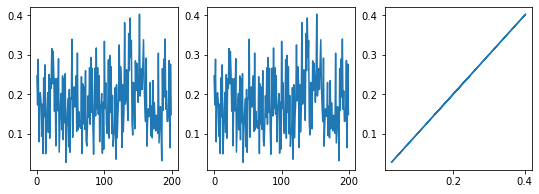

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].plot(tt1)
ax[1].plot(tt2)
ax[2].plot(tt1,tt2)

plt.show()